# Lecture 4: Grover search algorithm

<center><img src="../figures/dall-e/merlion_grover.png" alt="drawing" width="400"/></center>
<center><strong>Fig. 4:</strong> Who put sugar in the merlion coffee? [DALL-E].</center>

## Introduction

The Grover algorithm is probably one of the most famous quantum computing proof of utility. 

It has been known as "Grover search algorithm" because it is effective in a context in which we aim to find a specific solution of a problem among a set of possible solutions. 

#### Problem setup

In this notebook, we are going to implement the Grover algorithm using a system of $N$ qubits in order to explore a set of $2^N$ possible solutions and, without going deep into the mathematical details, we will proof we need a number of Grover iterations proportional to $\sqrt{N}$ to find the target solution with probability close to one.

---

To give the lesson a more concrete aspect, let's take a more realistic problem: 
Suppose you're at a party with $2^N$ friends. While you're peacefully drinking your coffee, you get distracted for a moment, and someone, without you noticing, pours sugar into your coffee.

It's a disaster because you like your coffee bitter! So, you absolutely need to find the person responsible for this.

Let's also suppose that there is no concrete evidence that can lead us to the guilty person, however, while poursing coffee inside your mug, the thief left a hair inside the cup, which can be used to extract DNA.

Perfect! we can compare the guily DNA with that of every person who was at the party at that moment.

---

This problem can be **classically** tackled by checking all the people one by one and, in the worst case, it takes $M = 2^N$ attempts before finding the guily person in the group. On the other hand, using quantum computing and the Grover algorithm, we will see the solution can be found with a number of algorithm's calls that scales as $\sqrt{M}$: *we gain a quadratic speedup!*

Let's start investigating the culprit by importing some packages.

In [225]:
import random

import numpy as np
import matplotlib.pyplot as plt

import qibo
from qibo import gates, Circuit

from scripts import plotscripts, utils

In [226]:
qibo.set_backend(backend="qibojit", platform="numba")

[Qibo 0.2.4|INFO|2024-01-30 13:50:02]: Using qibojit (numba) backend on /CPU:0


Secondly, we need to generate a set of elements which can deal with a quantum computer and are able to represent all the possible solutions we want to explore. In practice, we create a set of $2^N$ bitstrings and we associate every person at the party to one of the bistrings. 

We use the function `scripts.utils.generate_bitstring_combination` to generate a list containing all the possible bitstrings of zeros and ones composed of $N$ bits.

In [227]:
# set the problem dimensionality --> the size of the set to be explored
n = 5
# set the number of shots (circuit's executions)
nshots = 100000

# call the bitstring generator
bitstrings = utils.generate_bitstring_combinations(n)

In [228]:
print(len(bitstrings) == 2**n)
print(f"A random bitstring: {random.choice(bitstrings)}")

len(bitstrings)

True
A random bitstring: 01101


32

Let's generate the list of people who were at the party.

In [229]:
# !pip install Faker 
from faker import Faker
fake = Faker()

In [230]:
names = []
for i in range(2**n):
    names.append(fake.name())

print(names)

['Dustin Anderson', 'Charles Roberts', 'Timothy Myers', 'Kelli Hines', 'Jorge Holloway', 'Bryan Rivera', 'Brandon Armstrong', 'Frank Rodriguez', 'Joseph Howell', 'Jennifer Pierce', 'Todd Russell', 'Allison Garcia', 'Andrea Cole', 'William Clark', 'David Weeks', 'Felicia Rowland', 'Melissa Ortega', 'Shannon Payne', 'Rhonda Kelley', 'Kimberly Winters', 'Christopher Elliott', 'Michael Green', 'Amy Harris', 'Christina Bautista', 'Kevin Dyer', 'Brandon Richardson', 'Ronald Garcia', 'Tristan Lee', 'Joshua Brown', 'Paul Stone', 'John Wood', 'Shawn Johnson']


In practice, we have now a list of strings, in which the element of index $k$ represents the $k$-th suspect among the people.

Let's assume the guily guy in the list is the number 11!

In [231]:
guilty_index = 11
print(f"Guilty index: {guilty_index}")
print(f"Guilty {names[guilty_index]} corresponding to state {bitstrings[guilty_index]}")

Guilty index: 11
Guilty Allison Garcia corresponding to state 01011


### Grover algorithm main ingredients

Now the problem is set up and we can focus on the Grover implementation. 

<center><img src="../figures/grover-circ.png" alt="drawing" width="800"/></center>
We need to follow some steps:

1. we prepare a system of $N+1$ qubits into the $|0^{\otimes N}\rangle |1\rangle$ state. The ancilla gate is the one prepared as usual into $|1\rangle$;
2. we apply Hadamard gates to all the qubits in order to create superposition of all the $2^N$ states of the input register. We call this superposed state $|s\rangle$;
3. we apply an **oracle** function $U_f$ to the qubits, which is constructed in order to detect the guily state among the others. In out narrative, it can be seen as the machine which process the DNA of the people, allowing to find the guily person. In a quantum computer notation, it is a set of operation which flips the sign of the amplitude of the state corresponding to the guily guy (the number 11 in our case).
4. we apply the **diffusion operator** $U_s = 2|s\rangle \langle s| - I$, whose effect consists in reflecting the amplitudes of the system about the average amplitude. In practice, acting together with the oracle over the superposed states, it increases the amplitude of the guilty state and decrease the one of the others.
5. we repeat the process a number of time proportional to $\sqrt{M}$ to find the guily guy state with probability close to one.

We see some more detail in the following cells. For now, we can start implementing all the elements of the Grover algorithm.

#### Initial and final layers of the circuit

Regardless of the number of times we repeat the application of $U_f$ and $U_s$, we need to build the initial and the final circuit layer.

In [232]:
# set the circuit and initial superposition
def grover_initial_layer(n):
    """Build the initial superposition in Grover circuit."""
    circuit = Circuit(n+1)
    circuit.add(gates.X(n))
    for q in range(n+1):
        circuit.add(gates.H(q))
    return circuit

# final measurements
def add_measurements(n):
    circuit = Circuit(n+1)
    circuit.add(gates.M(*range(n)))
    return circuit

Let's visualize the initial and final layer.

In [233]:
initial_c = grover_initial_layer(n) + add_measurements(n)
print(initial_c.draw())

q0: ─H───M─
q1: ─H───M─
q2: ─H───M─
q3: ─H───M─
q4: ─H───M─
q5: ─X─H───


With this setup, the final state is the equally superposed state and we expect uniformly distributed probabilities between all the available states.
To visualize it, we can use the `scripts.plotscripts.plot_probabilities` function, which shows the probability of each state calculated using the collected frequencies after executing the circuit `nshots` times.

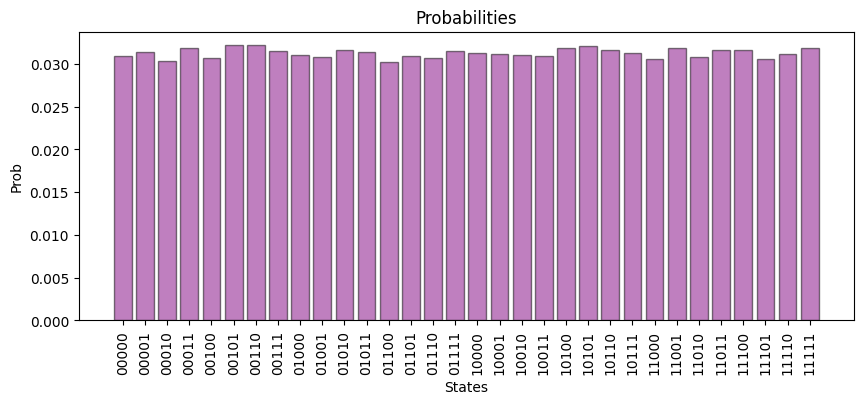

In [234]:
plotscripts.plot_probabilities(initial_c, nshots=nshots, grover=True)

As we can see from the plot, the state is prepared into $|s\rangle$.

#### Oracle 

We need now to construct the oracle $U_f$. This can be done firstly building a function:

$$ f: \{0,1\}^n \to \{0,1\} $$

which returns $1$ in the only case in which the input variable $p$ is the target one, otherwise it returns $0$. Given this, the oracle $U_f$ acts on the $N$-qubits state $|x\rangle$ in the following way: $$ U_f |x\rangle = (-1)^{f(x)}|x\rangle. $$

flipping the amplitude of the state only if $|x\rangle$ is the guily one:

$$ 
\begin{cases}
U_f\,|p\rangle = - |p\rangle \qquad \text{if} \quad |p\rangle \quad \text{guilty}, \\
U_f\,|p\rangle = + |p\rangle \qquad \text{if} \quad |p\rangle \quad \text{innocent}. \\
\end{cases}
$$

The easiest way to implement such an operator consists in building a multi-controlled gate which is "triggered" by the guilty state only. It means we need to define a gate which acts on an arbitrary qubit of the system (or on an ancilla qubit, like in this example) and, with its action, it provoke a phase kickback effect on the target state only. 

In order to build the aforementioned gate, we need to create an oracle such that it prepares the input register into the state $|1\rangle^{\otimes N}$. By doing this, we ensure the oracle action on the ancilla is triggered by the guilty state only.

In [361]:
def build_oracle(guilty_index, n):
    """Swap the guilty state."""
    bitstring = bitstrings[guilty_index]
    # 01011
    circuit = Circuit(n+1)
    targets = []
    for i, bit in enumerate(bitstring):
        if bit == "0":
            targets.append(i)
    [circuit.add(gates.X(q)) for q in targets]
    # triggered only if the control state is |111111>
    circuit.add(gates.X(q=n).controlled_by(*range(n)))
    [circuit.add(gates.X(q)) for q in targets]
    return circuit

Let's have a look to the circuit.

In [362]:
c = build_oracle(guilty_index=-1, n=n)
print(bitstrings[-1])
print(c.draw())

11111
q0: ─o─
q1: ─o─
q2: ─o─
q3: ─o─
q4: ─o─
q5: ─X─


Execute the whole circuit involving the oracle.

In [364]:
circuit = grover_initial_layer(n) + build_oracle(-1, n) + add_measurements(n)
print(circuit.draw())

q0: ─H───o─M─
q1: ─H───o─M─
q2: ─H───o─M─
q3: ─H───o─M─
q4: ─H───o─M─
q5: ─X─H─X───


In [365]:
# whole state
state = circuit().state()

print(f"Amplitudes (ancilla included):\n{state}\n")

# removing the dependence on the ancilla
amplitudes = []

for i in range(0, len(state), 2):
    amplitudes.append((1/np.sqrt(2))*(np.real(state[i])-np.real(state[i+1])))

print(f"Amplitudes (ancilla exluded):\n{amplitudes}\n")
print(f"Amplitude of the guily state: {amplitudes[guilty_index]}")

Amplitudes (ancilla included):
[ 0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j
  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j
  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j
  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j
  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j
  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j
  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j
  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j
  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j
  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j  0.125+0.j -0.125+0.j
  0.125+0.j -0.125+0.j -0.125+0.j  0.125+0.j]

Amplitudes (ancilla exluded):
[0.17677669529663678, 0.17677669529663678, 0.17677669529663678, 0.17677669529663678, 0.17677669529663678, 0.17677669529663678, 0.17677669529663678, 0.17677669529663678, 0.17677669529663678, 0.17677669529663678, 0.176776695

We can visualize the amplitudes of the input register using the function `script.plotscripts.plot_input_register_amplitudes`.

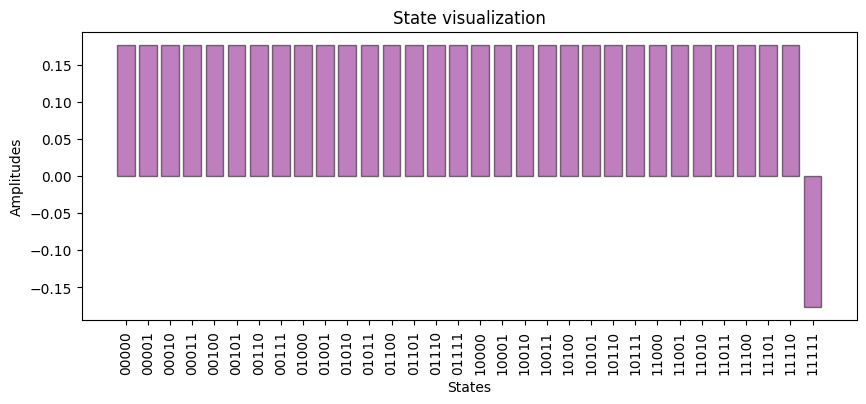

In [366]:
plotscripts.plot_input_register_amplitudes(circuit().state())

Even though the amplitude of the guily state is flipped, if we look to the probabilies associated to the states of the input register we still collect an equally superposed state.

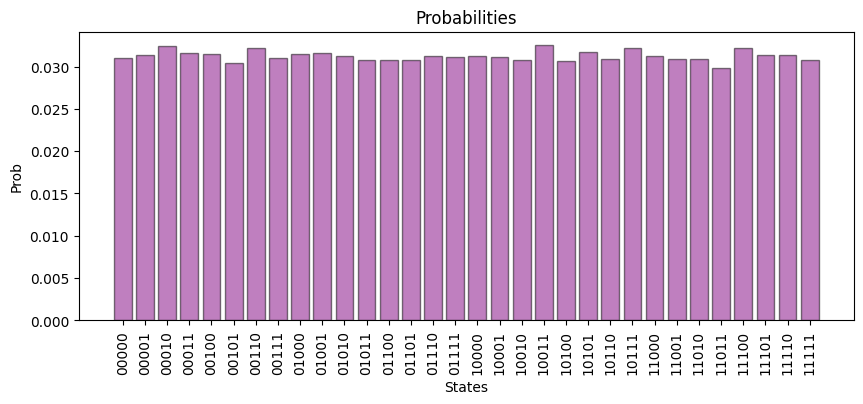

In [240]:
plotscripts.plot_probabilities(circuit, nshots=nshots, grover=True)

#### The diffusion operator

The next step in Grover is to implement the diffusion operator, whose effect is to amplify the guily amplitude while decreasing the others.
One way to implement this kind of operator is applying an Hadamard gate and a X gate to each qubit of the input register. These steps are useful to re-align all the qubits into the computational basis and then prepare them to the subsequent flip around the average. Then we apply a multi-controlled X gate to the ancilla qubit, and this is the fundamental step into the Grover diffusion operator: this action will create the phase flip of the qubits around the average superposed state. Finally, we apply again the X gates and the H gates, coming back to the superposed state and amplifying the target amplituted because of the interference.

In [367]:
def build_diffusion_operator(n):
    # n+1 qubits circuit
    circuit = Circuit(n+1)
    circuit.add(gates.X(n))
    for q in range(n):
        circuit.add(gates.H(q=q))
        circuit.add(gates.X(q=q))
    circuit.add(gates.X(q=n).controlled_by(*range(n)))
    for q in range(n):
        circuit.add(gates.X(q=q))
        circuit.add(gates.H(q=q))
    return circuit

In [368]:
print(build_diffusion_operator(n).draw())

q0: ─H─X─o─X─H─
q1: ─H─X─o─X─H─
q2: ─H─X─o─X─H─
q3: ─H─X─o─X─H─
q4: ─H─X─o─X─H─
q5: ─X───X─────


In [369]:
def build_grover(n, nsteps):
    """Build grover circuit with `n` qubits and repeating grover iteration `steps` times."""
    grover_c = Circuit(n+1)
    grover_c += grover_initial_layer(n)
    for _ in range(nsteps):
        grover_c += build_oracle(guilty_index, n)
        grover_c += build_diffusion_operator(n)
    grover_c += add_measurements(n)
    return grover_c

In [370]:
mean = (31*0.17677669529663678 - 0.17677669529663678) / 32
mean

0.165728151840597

In [371]:
alpha = 0.17677669529663678
- alpha + 2 * mean

0.15467960838455722

q0: ─H─X─o─X─H─X─o─X─H─M─
q1: ─H───o─H─X───o─X─H─M─
q2: ─H─X─o─X─H─X─o─X─H─M─
q3: ─H───o─H─X───o─X─H─M─
q4: ─H───o─H─X───o─X─H─M─
q5: ─X─H─X─X─────X───────
(0.10937+0j)|000000> + (-0.10937+0j)|000001> + (0.10937+0j)|000010> + (-0.10937+0j)|000011> + (0.10937+0j)|000100> + (-0.10937+0j)|000101> + (0.10937+0j)|000110> + (-0.10937+0j)|000111> + (0.10937+0j)|001000> + (-0.10937+0j)|001001> + (0.10937+0j)|001010> + (-0.10937+0j)|001011> + (0.10937+0j)|001100> + (-0.10937+0j)|001101> + (0.10937+0j)|001110> + (-0.10937+0j)|001111> + (0.10937+0j)|010000> + (-0.10937+0j)|010001> + (0.10937+0j)|010010> + (-0.10937+0j)|010011> + ...


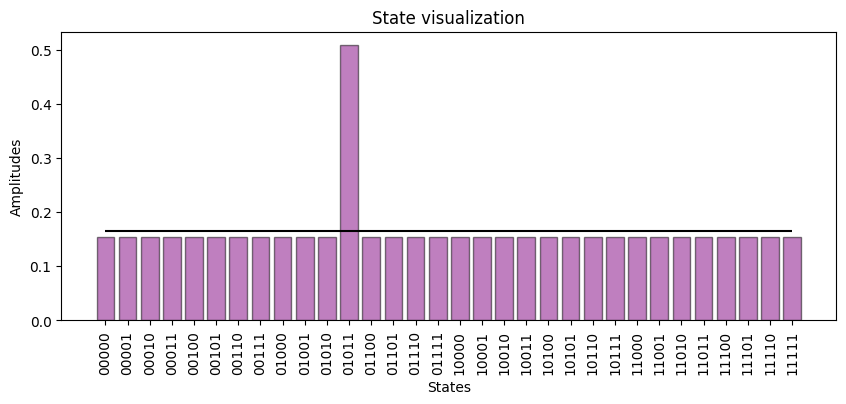

In [372]:
# build grover circuit with 1 step
grover_c = build_grover(n=n, nsteps=1)

# print the circuit
print(grover_c.draw())

print(grover_c())


# print probabilities
from importlib import reload
reload(plotscripts)
plotscripts.plot_input_register_amplitudes(grover_c().state(), hline=mean)

q0: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─M─
q1: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
q2: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─M─
q3: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
q4: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o─H─X───o─X─H─M─
q5: ─X─H─X─X─────X───────X─X─────X───────X─X─────X───────


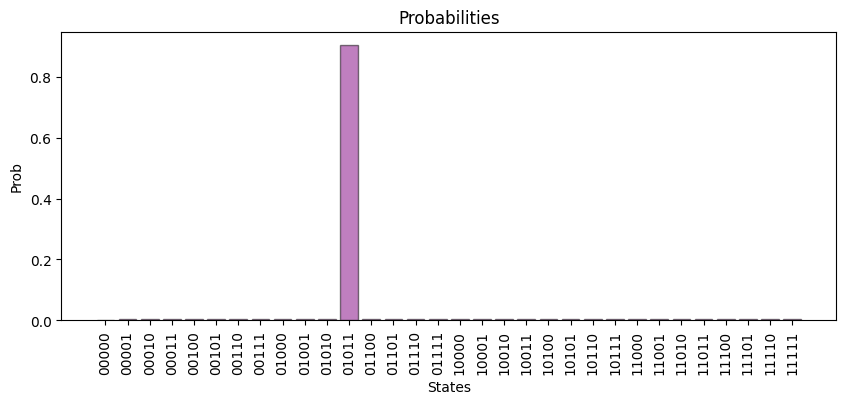

In [373]:
# build grover circuit with 2 step
grover_c = build_grover(n=n, nsteps=3)

# print the circuit
print(grover_c.draw())

# print probabilities
plotscripts.plot_probabilities(c=grover_c, nshots=nshots, grover=True)

From the plot and the amplitudes of the final state it is clearer and clearer who is the guily person!

In [375]:
state = grover_c().state()

# removing the dependence on the ancilla
amplitudes = []

for i in range(0, len(state), 2):
    amplitudes.append((1/np.sqrt(2))*(np.real(state[i])-np.real(state[i+1])))

probs = np.array(amplitudes)**2

index = np.argmax(probs)
print(f"The guily state is {bitstrings[index]} with probability {probs[index]}, corresponding to {names[index]}!")

The guily state is 01011 with probability 0.8969365358352603, corresponding to Allison Garcia!


We expect the optimal number of Grover steps is $\pi/4 \sqrt{M}$ from the theoretical results.
Let's check what happens with a growing number of steps.

In [335]:
opt = (np.pi / 4) * np.sqrt(2**n)
print(f"Optimal number of steps: {opt}")

Optimal number of steps: 4.442882938158366


In [336]:
prob_target = []
N = 10
# check for number of steps in np.arange(0, N)
for s in range(N):
    grover_c = build_grover(n=n, nsteps=s)
    prob_target.append(utils.compute_max_probability(c=grover_c, nshots=nshots))

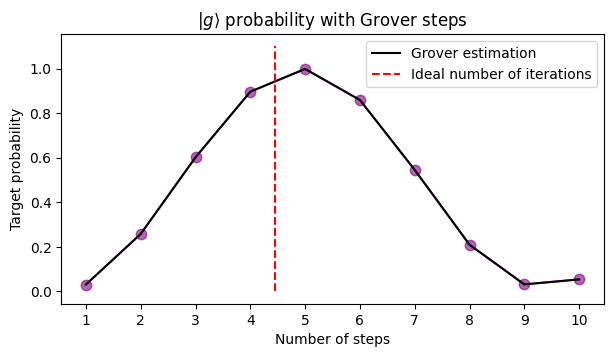

In [337]:
plt.figure(figsize=(7, 7*4/8))
plt.plot(np.arange(1, N+1), prob_target, ls="-", marker=".", markersize=15, alpha=0.6, color="purple")
plt.plot(np.arange(1, N+1), prob_target, ls="-", color="black", label="Grover estimation")
plt.vlines(opt, 0, 1.1, color="red", ls="--", label="Ideal number of iterations")
plt.xticks(np.arange(1, N+1))
plt.title(r"$|g\rangle$ probability with Grover steps")
plt.xlabel("Number of steps")
plt.ylabel("Target probability")
plt.legend()
plt.show()